In [ ]:
#######################
###### TODO FILL ######
#######################
 
#@title Author { run: "auto" }
NAME = "" #@param {type: "string"}
EMAIL = "" #@param {type: "string"}

# Audio and speech processing - Home assignment
**Author: Katerina Zmolikova, izmolikova@fit.vutbr.cz**

In this homework, you will work with audio data, learn to plot and listen to them, and do a simple speaker verification with a pre-trained model. There are several places in the notebook, where you are asked to fill in your own code. These are:
1. Recording and plotting your own signals.
2. Scoring set of target and non-target trials with speaker verification model.
3. Listening to the trials, which were classified the worst.
4. Running speaker verification with your own recording.

**Before you start filling the assignment, download the necessary 
[files](https://drive.google.com/file/d/1DRe9732g7eM3TdqU1t1j3E9vHrYiznKh/view?usp=sharing), unzip them and place them to your Colab Notebook (Folder icon on the left > File icon with the up arrow).** This should result in having a text files `trial` and a directory `wavs` with 15 wav files inside.

## How to submit
* Create a **copy** of this notebook.
* Finish the assignment.
* Export the notebook to `.pdf` (File > Print).
* Send it to izmolikova@fit.vutbr.cz (Add the pdf in the attachment).
* If you have any questions, contact me at the same email.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf # For loading audio signals into numpy arrays.
import IPython.display as dsp # For playing the audio.
from pathlib import Path # For working with the file system.
import os
from scipy.spatial.distance import cosine # For computing cosine distance.

In [ ]:
%matplotlib inline

In [ ]:
!pip install speechbrain

In [ ]:
import torchaudio # For loading audio signals directly into torch tensors.
from speechbrain.pretrained import EncoderClassifier # For loading pre-trained speaker verification model.

# Loading and plotting signal

In the first part of the assignment, we will look at how to plot audio recordings, their spectrograms and how to listen to them directly in the notebook. We will use one of the provided wav files, which was taken from [Voxceleb dataset](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/). First, let's simply read the signal, using `soundfile` library. The command `sf.read` will return two variables:
* the signal itself as a `numpy` array.
* sampling frequency --- this denotes how many samples per second the wav file has. Here, we will work with signal with 16000 Hz sampling frequency (16000 samples per second).

In [ ]:
s,fs = sf.read('wavs/id01224_irx71tYyI-Q.wav')

In [ ]:
print(f'Sampling frequency is {fs}.')
print(f'Number of samples in the signal is {s.shape[0]}, corresponding to {s.shape[0] / fs} seconds.')

Sampling frequency is 16000.
Number of samples in the signal is 69632, corresponding to 4.352 seconds.


Next, we will plot the loaded signal and play it.

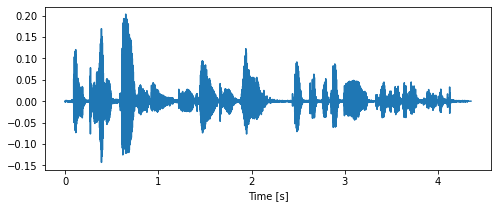

In [ ]:
plt.figure(figsize=(8,3))
t = np.arange(s.shape[0]) / fs # time axis
plt.plot(t, s)
plt.gca().set_xlabel('Time [s]')
plt.show()

In [ ]:
dsp.display(dsp.Audio(s, rate=fs))

Next, let's plot a short (100 millisecond long) segment from the signal. When indexing the numpy array, we need to index in samples. Notice that in this part of the signal, we can see a periodic behavior. The period seems to repeat about 3 times per 0.02 seconds, which corresponds to 150 times per second. This means that the base frequency of the voice of the speaker is about 150 Hz. This is the frequency with which the vocal folds vibrate.

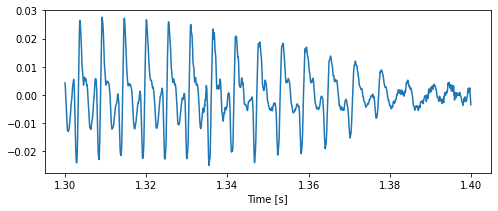

In [ ]:
from_sec = 1.3 # beginning of the segment in seconds
to_sec = 1.4 # end of the segment in seconds
from_sample = int(from_sec * fs) # beginning of the segment in samples
to_sample = int(to_sec * fs) # end of the segment in samples

plt.figure(figsize=(8,3))
plt.plot(t[from_sample:to_sample], s[from_sample:to_sample])
plt.gca().set_xlabel('Time [s]')
plt.show()

Finally, we will plot the spectrogram, showing us the time-frequency behavior of the signal. At some parts (e.g. right before 0.5 second mark) you can notice repeating lines at multiplies of the base frequency (150 Hz). These are the voiced parts of the speech.

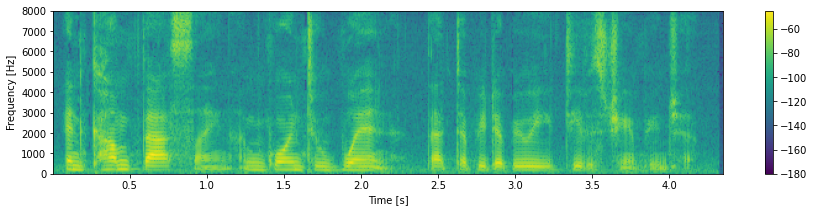

In [ ]:
plt.figure(figsize=(15,3))
t = np.arange(s.shape[0]) / fs # time axis
plt.specgram(s, Fs=fs)
plt.gca().set_xlabel('Time [s]')
plt.gca().set_ylabel('Frequency [Hz]')
plt.colorbar()
plt.show()

# Loading and plotting your own signals

In this part, you will read and plot your own recorded signals. For a guide on how to record in the proper format, please see the provided Google Doc "How to record audio in given format". After recording, upload your files to the notebook (folder icon on the left, then upload icon). 

Your task has three parts explained below. All commands that you need to complete the tasks should be in the section above.

1.   Record three signals:
*   First one: talking for about 5 seconds (you can for example read a piece of text or just talk spontaneously).
*   Second one: saying 'aaaaaaaaaa' (or a different vowel).
*   Third one: saying 'sssssssssss'.

Record the signal into a WAV file with sampling frequency 16000 Hz, sample size 16 bit and signed-integer encoding. 
2.   Plot signal and spectrogram of the first one of the recordings (you talking for 5 seconds).
3.   Plot a small segment (about 100 miliseconds) of the second and thrid recording ('aaaaaa' and 'ssssss'). On the recording with 'aaaaaaa' you should see the periodic behavior. Estimate how many times per second the period repeats. This is the frequency with which your vocal folds vibrate.



In [ ]:
# Placeholder for your code
# Loading your signals

In [ ]:
# Placeholder for your code
# Plotting the first signal

In [ ]:
# Placeholder for your code
# Plotting the spectrogram of the first signal.

In [ ]:
# Placeholder for your code
# Plotting 100 milisecond segment of 'aaaaaa'

In [ ]:
# Placeholder for your code
# Plotting 100 milisecond segment of 'ssssss'.

# Speaker verification

In this part of the assignment, we will use a speaker verification model to extract speaker embeddings from several recordings and compute distances between the extracted embeddings. First, we will load a pre-trained speaker verification model. This model was trained on [VoxCeleb](https://www.robots.ox.ac.uk/~vgg/data/voxceleb/) data. You can find more information about the model [here](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb).

In [ ]:
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-xvect-voxceleb", savedir="pretrained_models/spkrec-xvect-voxceleb")

With the model, we will score speaker verification trials. This means given a pair of recordings, we want to decide whether the speech at the recordings was spoken by the same speaker or two different speakers. To do this, we will extract a speaker embedding from each of the two recordings and then get a score by computing cosine distance between the embeddings. When the two recordings are of the same speaker, the score should be lower, while when they are from two different speakers, the score should be higher.



First, we load a text file with definition of the trials. Each line in this file is as follows:

`[name-of-first-recording] [name-of-second-recording] [target/nontarget]`

When the last column is `target`, both recording are from the same speaker. When the last column is `nontarget`, each recording is from different speaker. The recordings, including their speaker labels,  are taken from VoxCeleb test set. 

We will load the trials into two lists, one for target, one for non-target. Each element of the list is a tuple containing names of both files.

In [ ]:
with open('trials') as f:
  trials = [line.strip().split() for line in f]
trials_target = [(trial[0],trial[1]) for trial in trials if trial[2] == 'target']
trials_nontarget = [(trial[0],trial[1]) for trial in trials if trial[2] == 'nontarget']

In [ ]:
trials_target[0]

('id05999_ZQJVmCJFjNs.wav', 'id05999_Lri_u9ukuEw.wav')

We will first inspect the first target trial. We load and play both of the recordings. Notice that here, we use `torchaudio.load` rather than `sf.read` for reading the audio files. `torchaudio.load` loads the files directly into torch tensor, which is convenient for using it as the input of our model. However, when we want to plot or play the loaded signals, we need to use `.numpy()` to convert them to numpy array.

In [ ]:
s1, fs = torchaudio.load(f'wavs/{trials_target[0][0]}')
s2, fs = torchaudio.load(f'wavs/{trials_target[0][1]}')

dsp.display(dsp.Audio(s1.numpy(), rate=fs))
dsp.display(dsp.Audio(s2.numpy(), rate=fs))

We extract the embeddings from both loaded signals. The model returns the embedding with shape `(1,1,512)`. We are interested only in the last dimension, which is the dimension of the embedding itself. 

In [ ]:
emb1 = classifier.encode_batch(s1)[0][0]
emb2 = classifier.encode_batch(s2)[0][0]

Finally, we compute the cosine distance between the two embeddings.

In [ ]:
dist = cosine(emb1, emb2)
print(f'Distance of the speaker embeddings (the score of the trial) is {dist}.')

Distance of the speaker embeddings (the score of the trial) is 0.05751681327819824.


**Here comes your task:**
Extract the scores (cosine distances) for all target and non-target trials. For this, you need to load the audio from the files, extract the speaker embeddings and compute the cosine distance between them. Store the target trial scores in list `scores_target` and non-target scores in list `scores_nontarget`. 

In [ ]:
scores_target = []

for u1, u2 in trials_target:
  # Your code

In [ ]:
scores_nontarget = []

for u1, u2 in trials_nontarget:
  # Your code

Now, we can plot a histogram of all scores. For this, we use `matplotlib` command `plt.hist`, with additional parameters:
* `color` - we use green for target trials and red for non-target
* `alpha` - setting transparency of the histograms, so that we nicely see the overlapping parts
* `range` - controlling the lowest and highest value of which the histograms are computed. Change if you use the same on different recordings and get scores in different interval.
* `bins` - number of bins of the histogram.

In the histogram, you should see target green scores to be lower than non-target red scores, with some overlap. 

By looking at the histogram, decide on score which you would use as the threshold. Everything higher than this threshold is classified as non-target. Everything lower than this threshold is classified as target. (There are no right or wrong answers here. Simply look at the scores and think about how the choice of threshold affects the type of errors that you would get and how in different applications, you could set the threshold differently.)

In [ ]:
plt.figure()
plt.hist(scores_target, color='green', alpha=0.5, range=[0,0.2], bins=50)
plt.hist(scores_nontarget, color='red', alpha=0.5, range=[0,0.2], bins=50)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

From the histogram, you can see that any threshold you choose, there will be always some recordings classified wrongly. Let's inspect the recordings with the worst scores - this means target trial with highest score and non-target trial with lowest score.

Your task here, is to load and play the recordings from the worst trials (two from the worst target trial, and two from the worst non-target trial). Do the speaker in the target trial sound similar to you? Do the speakers from the non-target trial sound different to you? Does it make sense that our model made a mistake here?

In [ ]:
trials_target[np.argmax(scores_target)]

('id01224_p5_34aFNpBc.wav', 'id01224_w6c2fGhQPhg.wav')

In [ ]:
# Placeholder for you code
# Play the two signals from the worst target-trial. Does it sound like the same speaker in both?

In [ ]:
trials_nontarget[np.argmin(scores_nontarget)]

('id05999_ZQJVmCJFjNs.wav', 'id07426_UIJfsjsXBUc.wav')

In [ ]:
# Placeholder for you code
# Play the two signals from the worst nontarget-trial. Does it sound like different speakers?

# Speaker verification with your own recording

In the last part of the assignment, you will use your own recording and compare it with all the recordings from the `wavs` directory. For this, use the recording of you talking freely for five seconds. The solution should follow the same logic as above with trials being tuples of `(your-recording,recording-from-wav-directory)` --- fifteen trials in total. Ideally, you should see that all trials get higher score than your chosen threshold -> they are classified as different speaker.

In [ ]:
threshold = # insert your chosen threshold here

In [ ]:
# Placeholder for you code
# Get scores comparing your own recording to all recordings from 'wavs' directory.

all_wavs = os.listdir('wavs')

scores_yours = []

In [ ]:
# How many times was your recording correctly classified as different speaker?
np.sum(np.array(scores_yours) > threshold)